In [44]:
from pathlib import Path
import os
import shutil
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models
from torchvision.transforms import v2 as transforms
from torchvision.transforms.v2 import functional as F
from tqdm import tqdm
from torchvision import transforms

In [10]:
IMG_FORMATS = {"bmp", "dng", "jpeg", "jpg", "mpo", "png", "tif", "tiff", "webp", "pfm"}


def dirwalk(folder: str | Path):
    folder = Path(folder)

    if folder.suffix.lower()[1:] in IMG_FORMATS:
        return [folder]
    else:
        files = sorted(
            x for x in folder.rglob("*.*") if x.suffix[1:].lower() in IMG_FORMATS
        )
        return files

In [36]:
def get_shapes(images: list):
    return np.stack([cv2.imread(image).shape[:2] for image in images], axis=0)

def average(lst: list[float | int]) -> float | int:
    return sum(lst) / len(lst)

def average_shape(images: list):
    shapes = [Image.open(image).size for image in images]
    average_width = average([width for width, _ in shapes])
    average_height = average([height for _, height in shapes])

    return average_width, average_height

In [37]:
images = dirwalk("/mnt/data/src/bait/train/sim/data_sim_processed/val")
print(len(images))

19385


In [ ]:
shapes = get_shapes(images)
shapes

array([[ 358,  163],
       [ 279,  108],
       [ 227,   84],
       ...,
       [1276, 2100],
       [1417, 2523],
       [1688, 1818]])

In [40]:
shapes.shape

(19385, 2)

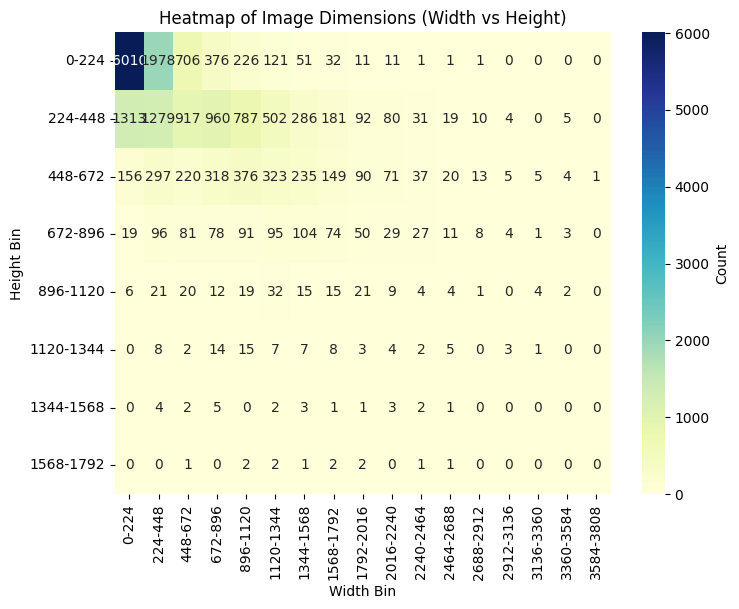

In [47]:
heights = shapes[:, 0]
widths = shapes[:, 1]

height_bins = np.arange(0, heights.max() + 1, 224)
width_bins = np.arange(0, widths.max() + 1, 224)

hist2d, xedges, yedges = np.histogram2d(widths, heights, bins=[width_bins, height_bins])
plt.figure(figsize=(8, 6))
sns.heatmap(hist2d.T, annot=True, fmt="g", cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.xlabel("Width Bin")
plt.ylabel("Height Bin")
plt.title("Heatmap of Image Dimensions (Width vs Height)")
plt.xticks(ticks=np.arange(len(width_bins) - 1) + 0.5, labels=[f"{int(width_bins[i])}-{int(width_bins[i+1])}" for i in range(len(width_bins) - 1)], rotation=90)
plt.yticks(ticks=np.arange(len(height_bins) - 1) + 0.5, labels=[f"{int(height_bins[i])}-{int(height_bins[i+1])}" for i in range(len(height_bins) - 1)], rotation=0)
plt.show()

In [48]:
heights.mean(), widths.mean()

(np.float64(282.4922878514315), np.float64(559.1334537013155))

## Functions to split folders

In [2]:
def create_splits(root_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1.0"

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    train_dir = os.path.join(output_dir, "train")
    val_dir = os.path.join(output_dir, "val")
    test_dir = os.path.join(output_dir, "test")

    for subdir in [train_dir, val_dir, test_dir]:
        if not os.path.exists(subdir):
            os.makedirs(subdir)

    not_enough_folders = 0

    for class_dir in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_dir)
        if not os.path.isdir(class_path):
            continue

        images = [
            img
            for img in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, img))
        ]
        random.shuffle(images)

        num_images = len(images)

        if num_images <= 6:
            not_enough_folders += 1
            continue

        num_train = int(num_images * train_ratio)
        num_val = int(num_images * val_ratio)
        num_test = num_images - num_train - num_val

        # Ensure each split has at least 2 images
        if num_train < 2:
            num_train = 2
        if num_val < 2:
            num_val = 2
        if num_test < 2:
            num_test = 2

        # Adjust splits to maintain the total count
        total_assigned = num_train + num_val + num_test
        if total_assigned > num_images:
            difference = total_assigned - num_images
            if num_train - difference >= 2:
                num_train -= difference
            elif num_val - difference >= 2:
                num_val -= difference
            else:
                num_test -= difference

        train_images = images[:num_train]
        val_images = images[num_train : num_train + num_val]
        test_images = images[num_train + num_val : num_train + num_val + num_test]

        for img in train_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(train_dir, class_dir)
            if not os.path.exists(dst):
                os.makedirs(dst)
            shutil.copy(src, dst)

        for img in val_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(val_dir, class_dir)
            if not os.path.exists(dst):
                os.makedirs(dst)
            shutil.copy(src, dst)

        for img in test_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(test_dir, class_dir)
            if not os.path.exists(dst):
                os.makedirs(dst)
            shutil.copy(src, dst)

In [3]:
def create_splits(root_dir, output_dir, train_ratio=0.8, val_ratio=0.2):
    assert train_ratio + val_ratio == 1.0, "Ratios must sum to 1.0"

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    train_dir = os.path.join(output_dir, "train")
    val_dir = os.path.join(output_dir, "val")

    for subdir in [train_dir, val_dir]:
        if not os.path.exists(subdir):
            os.makedirs(subdir)

    not_enough_folders = 0

    for class_dir in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_dir)
        if not os.path.isdir(class_path):
            continue

        images = [
            img
            for img in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, img))
        ]
        random.shuffle(images)

        num_images = len(images)

        if num_images < 4:
            not_enough_folders += 1
            continue

        num_train = int(num_images * train_ratio)
        num_val = num_images - num_train

        # Ensure each split has at least 2 images
        if num_train < 2:
            num_train = 2
        if num_val < 2:
            num_val = 2

        # Adjust splits to maintain the total count
        total_assigned = num_train + num_val
        if total_assigned > num_images:
            difference = total_assigned - num_images
            if num_train - difference >= 2:
                num_train -= difference
            elif num_val - difference >= 2:
                num_val -= difference

        train_images = images[:num_train]
        val_images = images[num_train:]

        for img in train_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(train_dir, class_dir)
            if not os.path.exists(dst):
                os.makedirs(dst)
            shutil.copy(src, dst)

        for img in val_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(val_dir, class_dir)
            if not os.path.exists(dst):
                os.makedirs(dst)
            shutil.copy(src, dst)

    return not_enough_folders

In [35]:
def find_folders_with_file_count(parent_folder, desired_file_count):
    matching_folders = []
    for folder in os.listdir(parent_folder):
        folder_path = os.path.join(parent_folder, folder)
        if os.path.isdir(folder_path):
            file_count = len(
                [
                    name
                    for name in os.listdir(folder_path)
                    if os.path.isfile(os.path.join(folder_path, name))
                ]
            )
            if file_count < desired_file_count:
                matching_folders.append(folder_path)
    return matching_folders

In [5]:
def create_n_splits(root_dir, output_dir, train_ratio=0.9, val_ratio=0.1, n=1):
    assert train_ratio + val_ratio == 1.0, "Ratios must sum to 1.0"

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    train_dir = os.path.join(output_dir, "train")
    val_dir = os.path.join(output_dir, "val")

    for subdir in [train_dir, val_dir]:
        if not os.path.exists(subdir):
            os.makedirs(subdir)

    not_enough_folders = 0

    for class_dir in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_dir)
        if not os.path.isdir(class_path):
            continue

        images = [
            img
            for img in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, img)) and \
                not img.lower().startswith("auga_")
        ]
        random.shuffle(images)

        num_images = len(images)

        if num_images < 2*n:
            not_enough_folders += 1
            continue

        num_train = int(num_images * train_ratio)
        num_val = num_images - num_train

        # Ensure each split has at least n images
        if num_train < n:
            num_train = n
        if num_val < n:
            num_val = n

        # Adjust splits to maintain the total count
        total_assigned = num_train + num_val
        if total_assigned > num_images:
            difference = total_assigned - num_images
            if num_train - difference >= n:
                num_train -= difference
            elif num_val - difference >= n:
                num_val -= difference

        train_images = images[:num_train]
        val_images = images[num_train:]

        for img in train_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(train_dir, class_dir)
            if not os.path.exists(dst):
                os.makedirs(dst)
            shutil.copy(src, dst)

        for img in val_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(val_dir, class_dir)
            if not os.path.exists(dst):
                os.makedirs(dst)
            shutil.copy(src, dst)

    return not_enough_folders

In [6]:
def process(root_dir, output_dir, n=2):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    not_enough_folders = 0

    for class_dir in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_dir)
        if not os.path.isdir(class_path):
            continue

        images = [
            img
            for img in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, img)) and \
                not img.lower().startswith("auga_")
        ]
        random.shuffle(images)
        num_images = len(images)

        if num_images < n:
            not_enough_folders += 1
            continue
        
        for img in images:
            src = os.path.join(class_path, img)
            dst = os.path.join(output_dir, class_dir)
            if not os.path.exists(dst):
                os.makedirs(dst)
            shutil.copy(src, dst)
        
    return not_enough_folders

## Mine dataset

In [14]:
def get_info(source_directory):
    all_classes = os.listdir(source_directory)
    all_images = []
    for root, dirs, files in os.walk(source_directory):
        for file in files:
            if file.lower().endswith((".jpg",)):
                all_images.append(os.path.join(root, file))


    return all_classes, all_images

In [15]:
source_directory = "/mnt/data/data/Data_Sim"
all_classes, all_images = get_info(source_directory)
print(f"Number of classes: {len(all_classes)}")
print(f"Number of images: {len(all_images)}")

Number of classes: 31044
Number of images: 258317


## Remove auga

In [16]:
dest_directory = "../data_sim_31k/Data_Sim_Org"
process(source_directory, dest_directory)

267

In [17]:
all_classes, all_images = get_info(dest_directory)
print(f"Number of classes: {len(all_classes)}")
print(f"Number of images: {len(all_images)}")

Number of classes: 30777
Number of images: 118413


## Aug again

In [27]:
# !mv ../data_sim_31k/Data_Sim_Org ../data_sim_31k/Data_Sim_Aug
# !cp -r ../data_sim_31k/Data_Sim_Aug/* ../data_sim_31k/Data_Sim_Org


In [28]:
def augment_and_save_image(subdir, image_name, transform, num_augmentations=2):
    image = Image.open(os.path.join(subdir, image_name + ".jpg"))
    for i in range(num_augmentations):
        augmented_image = transform(image)
        augmented_name = f"auga_{i}__{image_name}.jpg"
        augmented_path = os.path.join(subdir, augmented_name)
        augmented_image.save(augmented_path)

def aug(source_directory, transform, num_augmentations=2):
    for subdir, _, files in os.walk(source_directory):
        for file in tqdm(files):
            if file.endswith(('jpg',)):
                image_name = file.split(".")[0]
                augment_and_save_image(subdir, image_name, transform, num_augmentations)

In [24]:
import os
import random
from PIL import Image
from torchvision import transforms


transform = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.5, contrast=0.5),
        transforms.RandomRotation(30),
        transforms.GaussianBlur(kernel_size=3),
    ],
)

In [29]:
aug_directory = "../data_sim_31k/Data_Sim_Aug"
aug(aug_directory, transform)

In [34]:
all_classes, all_images = get_info(aug_directory)
print(f"Number of classes: {len(all_classes)}")
print(f"Number of images: {len(all_images)}")

Number of classes: 30777
Number of images: 355239


# Split train test

In [31]:
def horizontal_split(root_dir, output_dir, train_ratio=0.9, val_ratio=0.1):
    assert train_ratio + val_ratio == 1.0, "Ratios must sum to 1.0"

    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    class_folders = [f.name for f in os.scandir(root_dir) if f.is_dir()]
    random.shuffle(class_folders)

    split_idx = int(len(class_folders) * train_ratio)
    
    # Split folders into train and validation sets
    train_folders = class_folders[:split_idx]
    val_folders = class_folders[split_idx:]

    for folder in train_folders:
        src = os.path.join(root_dir, folder)
        dest = os.path.join(train_dir, folder)
        shutil.copytree(src, dest)
        
    for folder in val_folders:
        src = os.path.join(root_dir, folder)
        dest = os.path.join(val_dir, folder)
        shutil.copytree(src, dest)

In [32]:
final_dir = "../data_sim_31k/Data_Sim_Aug_Split"
horizontal_split(aug_directory, final_dir, 0.9, 0.1)


In [36]:
train_directory = os.path.join(final_dir, "train")
val_directory = os.path.join(final_dir, "val")

print(find_folders_with_file_count(train_directory, 6))
print(find_folders_with_file_count(val_directory, 6))

[]
[]


In [37]:
all_classes, all_images = get_info(train_directory)
print(f"Number of classes: {len(all_classes)}")
print(f"Number of images: {len(all_images)}")

Number of classes: 27699
Number of images: 320247


In [39]:
all_classes, all_images = get_info(val_directory)
print(f"Number of classes: {len(all_classes)}")
print(f"Number of images: {len(all_images)}")

Number of classes: 3078
Number of images: 34992
